<a href="https://colab.research.google.com/github/tzoung-yu/TrueVolume/blob/main/%E7%B0%A1%E6%98%8ETrueVolume%E4%B8%8A%E5%B8%82%E4%B8%8A%E6%AB%83_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2024-05-01 03:35:28.959 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2377


2024-04-30  159.5 量: 2703


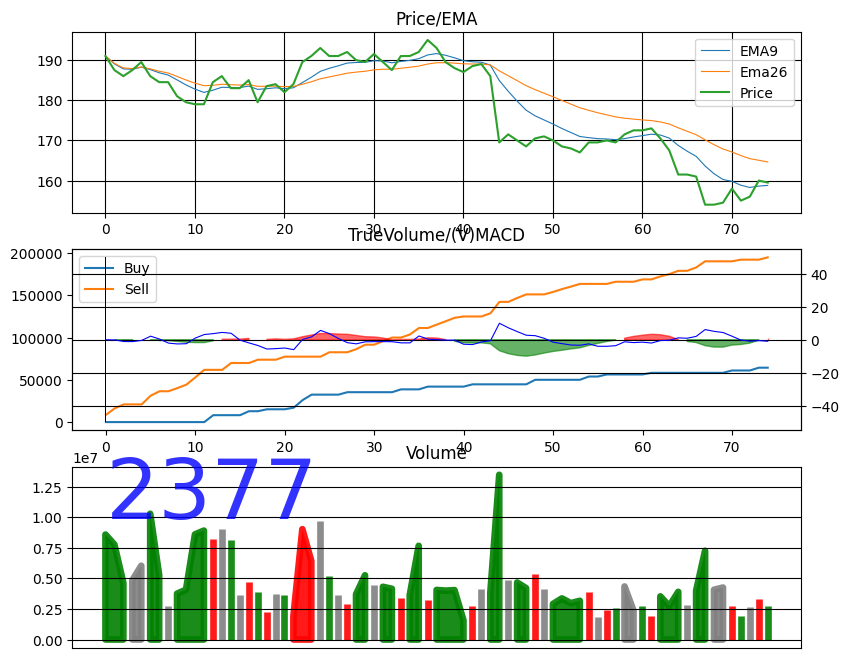

In [ ]:
!pip install twstock >log.txt
#!twstock -U
import twstock
from twstock import Stock
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import matplotlib as mpl
import yfinance as yf
import pandas as pd
import requests
import time
with_fmind = 1
!pip install FinMind > log.txt
from FinMind.data import DataLoader
fmind = DataLoader()

#股票代號
stoid='2377'

thisday = datetime.today()
day_start = thisday - timedelta(days=400)
draw_start = thisday - timedelta(days=120)
#day_start = thisday.replace(month=1, day=1)

def TrueVol(pd):
  df=pd
  global thisday
  global draw_start
  end_date = thisday
  start_date = draw_start
  df = df[df['Date'].between(start_date, end_date)]
  df = df.reset_index(drop=False)
  opp=df['Open']
  clo=df['Close']
  voo=df['Volume']
  hig=df['High']
  llo=df['Low']
  upl=[]
  dol=[]
  bll=[]
  upc=0.0
  dlc=0.0
  blc=0.0
  lp=0.0
  lgv=1.0
  lgc=0.0
  upordown=0.0
  xvo=[]
  for i in range(len(opp)):
    if clo[i]>lgc:
      lgc=clo[i]
    if(lp==0.0):
      lp=opp[i]
    upordown=0
    if opp[i]>=lp:
      if clo[i]>lp and (clo[i]> opp[i] + ((hig[i] - opp[i])/2.38) or clo[i] >= lp + ((hig[i] - lp)/1.88)):
        upc+=(voo[i]/1000)
        upordown=1
      else:
        if clo[i]<lp or clo[i]<llo[i]+((hig[i]-llo[i])/5.8):
          dlc+=(voo[i]/1000)
          upordown=-1
    else:
      if clo[i]<lp:
        dlc+=(voo[i]/1000)
        upordown=-1
      else:
        if clo[i]>lp+(hig[i]-lp)/2.38:
          upc+=(voo[i]/1000)
          upordown=1
    upl.append(upc)
    dol.append(dlc)
    blc+=voo[i]/1000
    bll.append(blc/2)
    xvo.append(upordown)
    lp=clo[i]
    if(voo[i]/1000 > lgv):
      lgv=voo[i]/1000

  ema10=clo.ewm(span=9).mean()
  ema30=clo.ewm(span=26).mean()

  Vol12     = voo.ewm(span=12).mean()
  Vol26     = voo.ewm(span=26).mean()
  Vacd      = Vol12 - Vol26
  Vsig = Vacd.ewm(span=9).mean()
  Vhistogram = Vacd - Vsig

  Ema12     = clo.ewm(span=12).mean()
  Ema26     = clo.ewm(span=26).mean()
  Macd      = Ema12 - Ema26
  sig = Macd.ewm(span=9).mean()
  histogram =Macd-sig

  gg1=10
  gg3=gg1/max(abs(Vhistogram))
  Vhistogram = Vhistogram*gg3

  #gg3=gg1/max(abs(Macd))
  #Macd = Macd*gg3

  gg3=gg1/max(abs(histogram))
  histogram = histogram*gg3

  x = np.arange(0, len(clo))

  mpl.rcParams["figure.figsize"] = (9.4, 8)

  plt.subplot(311)
  plt.plot(ema10, label='EMA9',linewidth=0.8)
  plt.plot(ema30, label='Ema26',linewidth=0.8)
  plt.plot(clo, label='Price')
  plt.legend()
  plt.grid(color='black')
  plt.title('Price/EMA')

  ax1 = plt.subplot(312)
  ax2 = ax1.twinx()
  ax1.plot(upl,label='Buy')
  ax1.plot(dol,label='Sell')
  ax1.legend()
  ax2.fill_between(x, histogram, where=(histogram>0), color='red', alpha=0.6)
  ax2.fill_between(x, histogram, where=(histogram<0), color='green', alpha=0.6)
  ax2.plot(Vhistogram, linewidth=0.8, color='blue')
  mm = max(abs(Vhistogram))*5
  xx = [0, 0]
  h = [0-mm, mm]
  ax2.bar(xx, h, 0.1, color='black',linewidth=0)
  plt.grid(color='black')
  plt.title('TrueVolume/(V)MACD')

  xvo = np.array(xvo)
  plt.subplot(313)
  plt.fill_between(x, voo, where=(xvo==0), color='gray', alpha=0.9, linewidth=4.8)
  plt.fill_between(x, voo, where=(xvo<0), color='green', alpha=0.9, linewidth=4.8)
  plt.fill_between(x, voo, where=(xvo>0), color='red', alpha=0.9, linewidth=4.8)
  plt.gca().xaxis.set_ticks([])
  plt.grid(color='black')
  plt.title('Volume')

  col3='blue'
  df1 = pd.set_index('Date')
  df1m = df1['Close'].resample('M').mean()
  if df1m[-1]>df1m[-2]:
    print("**月均線向上**")
    col3='gold'

  if col3=='gold' and Vhistogram.iloc[-2]<0 and (Vhistogram.iloc[-1]>Vhistogram.iloc[-2]):
    col3='pink'

  if col3=='pink' and upl[-1] > dol[-1]:
    col3 = 'brown'

  ytop=int(max(plt.ylim()))*0.7
  if col3=='gold' or col3=='pink' or col3=='brown':
    plt.annotate(stoid,xy=(0.2,ytop-0.5),color='black',alpha=0.8,fontsize=60)
  plt.annotate(stoid,xy=(0,ytop),color=col3,alpha=0.8,fontsize=60)

  plt.show()

def keep_first_line(text):
    lines = text.splitlines()
    if lines:
        return lines[0]
    else:
        return ""

codes = twstock.codes
df = pd.DataFrame.from_dict(codes, orient='index')

stoname=str(stoid)
if not stoname.isdigit():
  nn = df[df["name"] == stoname]
  stoid=str(int(nn.code.iloc[0]))

market='上櫃'
if with_fmind != 1:
  nn=df[df["code"]==stoid]
  print("")
  print(stoid, nn.name[0], nn.market[0],nn.group[0])
  market = nn.market[0]

# 讀取股價資料
if with_fmind!=1 and market=='上櫃':
  print("統計起始日:"+draw_start.strftime("%Y/%m"))
  stock = Stock(stoid)
  sto_price = stock.fetch_from(day_start.year, day_start.month)
  sto_attr = ['Date', 'Volume', 'Turnover', 'Open', 'High', 'Low', 'Close', 'Change', 'Transaction']
  data1 = pd.DataFrame(columns = sto_attr, data = sto_price)
  data1 = data1.drop(['Turnover', 'Change', 'Transaction'], axis=1)

if with_fmind==1 and market=='上櫃':
  data1 = fmind.taiwan_stock_daily(stock_id = stoid, start_date = day_start.strftime("%Y-%m-%d"))
  data1 = data1.drop(['Trading_money', 'stock_id', 'spread', 'Trading_turnover'], axis=1)
  data1.columns = ['Date', 'Volume', 'Open', 'High', 'Low', 'Close']
  data1.set_index("Date" , inplace=True)
  data1 = data1.set_index(pd.DatetimeIndex(pd.to_datetime(data1.index)))
  data1 = data1.reset_index(drop=False)

if market=='上市':
  print("統計起始日:"+draw_start.strftime("%Y/%m/%d"))
  data1 = yf.download(stoid+'.TW',start=day_start, end=thisday)
  data1 = data1.reset_index(drop=False)

is_closed = False
hour = thisday.hour+8
# 判斷現在時間是否在收盤後
if (thisday.weekday() in [5, 6]) or hour==8: #<13 or (hour==13 and thisday.minutes<=30):
  is_closed = False

dfl=data1.tail(1)
tt1=keep_first_line(str(dfl['Date']))
tt1=tt1[-10:]

realdone = False
if tt1==thisday.strftime("%Y-%m-%d"):
  realdone=True

while(is_closed and realdone == False):
  if market=='上市':
    url = "https://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=tse_"+stoid+".tw"
  if market=='上櫃':
    time.sleep(1)
    url = "https://mis.twse.com.tw/stock/api/getStockInfo.jsp?ex_ch=otc_"+stoid+".tw"
  res = requests.get(url)
  res = res.json()
  if(res['rtmessage'] == 'OK'):
    res = res['msgArray']
    df = pd.json_normalize(res)
    v=df['d']
    tt2 = str(v[0])
    date_object = datetime.strptime(tt2, "%Y%m%d")
    tt2 = date_object.strftime("%Y-%m-%d")
    if tt1==tt2:
      break
    b = df['pz']
    if b[0] == '-':
      b = df['b']
    b = str(b[0])
    if b == '-':
      break
    if b[:7]=='0.0000_':
      b=b[7:]
    if not b:
      break
    rlp = float(b[:7])
    if rlp==0.0:
       break
    v = df['o']
    ropen = float(v[0])
    v = df['h']
    rhigh = float(v[0])
    v = df['l']
    rlow = float(v[0])
    v = df['v']
    rtv = int(v[0])
    if market=='上櫃':
      data1.loc[len(data1)] = [datetime.strptime(tt2,"%Y-%m-%d"), rtv*1000, ropen, rhigh, rlow, rlp]
    if market=='上市':
      data1.loc[len(data1)] = [datetime.strptime(tt2,"%Y-%m-%d"), ropen, rhigh, rlow, rlp, rlp, rtv*1000]
    print("當日盤中資料已取得!")
  realdone = True

df=data1.tail(1)
tt1 = keep_first_line(str(df["Date"]))
tt1 = tt1[-10:]
tt2 = keep_first_line(str(round(df["Close"],2)))
tt2 = tt2[6:]
tt3 = keep_first_line(str(int(round(df["Volume"].iloc[0]/1000,0))))
print(tt1, tt2, "量:",tt3)

TrueVol(data1)